In [82]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

import matplotlib.pyplot as plt
import plotly.express as px
import os
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan


In [83]:
wines = pd.read_csv('datasets/winequality-all.csv')
wines.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,1,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,1,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [84]:
#sns.pairplot(wines)

In [85]:
x_vals = wines.drop('quality', axis=1)
y_val = wines.loc[:,'quality']

# split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_vals, y_val, test_size=0.2, random_state=42)

model = sm.OLS(y_train, x_train).fit()
print(model.summary())



                                 OLS Regression Results                                
Dep. Variable:                quality   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          2.723e+04
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                        0.00
Time:                        21:59:23   Log-Likelihood:                         -5773.8
No. Observations:                5197   AIC:                                  1.157e+04
Df Residuals:                    5185   BIC:                                  1.165e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

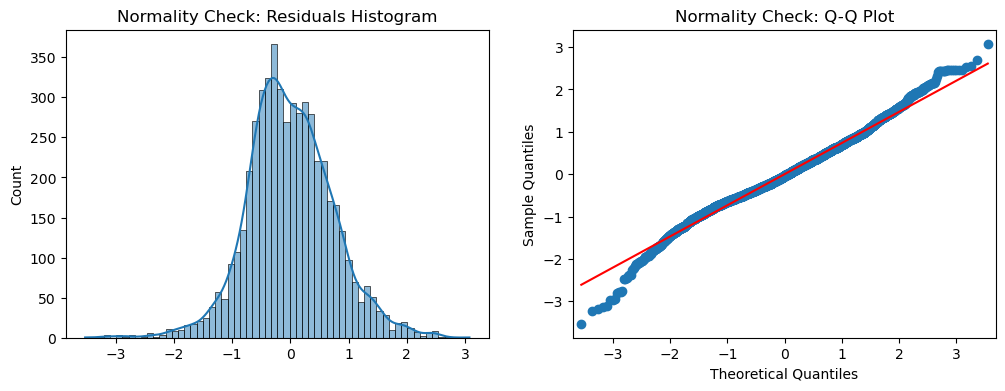

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(model.resid, ax=ax[0], kde=True)
ax[0].set_title("Normality Check: Residuals Histogram")
sm.qqplot(model.resid, ax=ax[1], line="s")
ax[1].set_title("Normality Check: Q-Q Plot")
plt.show()

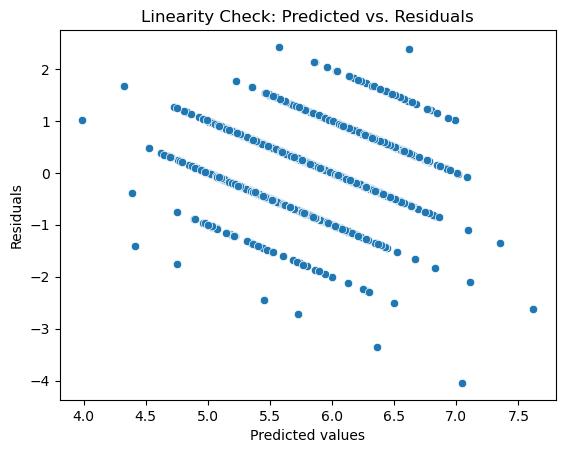

Breusch-Pagan test p-value: 0.0000
Breusch-Pagan test f-statistic p-value: 0.0000


In [87]:
#predict the target variable using the test set
y_pred = model.predict(x_test)

# calculate the residuals
residuals = y_test - y_pred

# plot the residuals against the predicted values
sns.scatterplot(x=y_pred, y=residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Linearity Check: Predicted vs. Residuals")
plt.show()


# perform the Breusch-Pagan test for heteroscedasticity
_, pvalue, _, f_pvalue = het_breuschpagan(residuals, x_test)
print(f"Breusch-Pagan test p-value: {pvalue:.4f}")
print(f"Breusch-Pagan test f-statistic p-value: {f_pvalue:.4f}")

In [88]:
# predict the target variable using the trained model
y_pred = model.predict(x_test)

# calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
rmse

0.738696104546948

Looks like linearity plot is not linear, thus, not really satisfying the linearity assumption. Moreover, looking at the Homoscedaciticity tests, we see the Breusch-Pagan test's pvlue should be >0.05 to indicate that the variance of the residuals is constant, but we have it less than 0.05. One of the possible solutions to improve our data is to apply transformers together with eliminating unnecessary feature for the furtehr analysis.

Let's try 3 different transformers on independent variables: Box-cox, Qualtile, and Yeo-Johnson transformers. We'll rate them by skeweness of tranformed distribution, and choose the one that has the least skeweness.

In [89]:
def tranforming_params(col):
    
    skewnesses = {}
    
    # let's isolate variable
    x_var = wines.loc[:,col]
    
    #let's try box-cox transformer first
    if not (True in (x_var < 1).unique()):
        x_var_transf,_ = boxcox(x_var)
        skewnesses['boxcox'] = pd.DataFrame(x_var_transf).skew()

    
    x_var = np.array(wines.loc[:,col])
    
    #let's try quantile transformer next
    quantile_transformer = QuantileTransformer(n_quantiles=3, random_state=0)
    x_var_transf = quantile_transformer.fit_transform(x_var.reshape(-1, 1))
    skewnesses['quantile'] = pd.DataFrame(x_var_transf).skew()

    # Apply the Yeo-Johnson transformation to the features
    pt = PowerTransformer(method="yeo-johnson", standardize=True)
    x_var_transf = pt.fit_transform(x_var.reshape(-1,1))
    skewnesses['yeo-johnson'] = pd.DataFrame(x_var_transf).skew()
    
    return skewnesses
    

In [90]:
wines_for_test = wines.drop('quality', axis =1)
#wines_for_test = wines_for_test.drop('type', axis =1)

best_for_col = {}

for col_name in wines_for_test.columns:
    
    tests = pd.DataFrame(tranforming_params(col_name))
    best_for_col[col_name] = tests.idxmin(1)[0]

best_for_col.values()

dict_values(['quantile', 'boxcox', 'quantile', 'quantile', 'quantile', 'quantile', 'quantile', 'quantile', 'quantile', 'quantile', 'quantile', 'quantile'])

In [91]:
transf_counts = {'quantile':0, 'boxcox':0, 'yeo-johnson': 0}

for value in best_for_col.values():
    transf_counts[value] = transf_counts[value] + 1
    
print(f'The best tranformer for our dataset is {max(transf_counts, key= lambda k:transf_counts[k])} tranformer; Let\'s tranform our dataset accordingly')

The best tranformer for our dataset is quantile tranformer; Let's tranform our dataset accordingly


In [92]:
# Initialize the QuantileTransformer object
qt = QuantileTransformer(output_distribution='normal')

# Apply quantile transformation on the dataframe
wines_transformed = pd.DataFrame(qt.fit_transform(wines.drop('quality', axis=1)), columns=wines.drop('quality', axis=1).columns)

wines_transformed['quality'] = wines['quality'] 

In [93]:
#sns.pairplot(wines_transformed)

Now, let's separate our transformed dataset into training and test datasets, and perform backwards elimination on regression model to exclude exclude unnecessary variables for further analysis.

In [94]:
# Step 1: Split the dataset into training and test sets

# separate the target variable (quality) from the features
x = wines_transformed.drop('quality', axis=1)
#x = x.drop('type', axis=1)
y = wines_transformed['quality']

# split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [95]:
# print the shape of the training and test sets
print('Training set shape:', x_train.shape, y_train.shape)
print('Test set shape:', x_test.shape, y_test.shape)

Training set shape: (5197, 12) (5197,)
Test set shape: (1300, 12) (1300,)


In [96]:
x.columns

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype='object')

In order to reduce overfitting, increase accuracy, and perhaps decrease computational power required for the work - we will try backward and forward elimination to see if we can exclude any features

In [97]:
def backward_elimination(x, y, significance_level=0.05):
    num_vars = len(x.columns)
    for i in range(0, num_vars):
        regressor_OLS = sm.OLS(y, x).fit()
        max_p_value = max(regressor_OLS.pvalues)
        if max_p_value > significance_level:
            for j in range(0, num_vars - i):
                if regressor_OLS.pvalues[j] == max_p_value:
                    x = x.drop(x.columns[j], axis=1)
        else:
            break
    return x

x_backward = backward_elimination(x, y)
print("Selected features after backward elimination:", list(x_backward.columns))

Selected features after backward elimination: ['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


No features were thrown away using backward elimination - let's try another method

In [98]:
# separate the target variable (quality) from the features
x = wines_transformed.drop('quality', axis=1)
#x = x.drop('type', axis=1)
y = wines_transformed['quality']

def forward_elimination(x, y, significance_level=0.05):
    initial_features = x.columns.tolist()
    best_features = []
    
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(x[best_features + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        
        min_p_value = new_pval.min()
        
        if min_p_value < significance_level:
            best_features.append(new_pval.idxmin())
        else:
            break
            
    return x[best_features]

x_forward = forward_elimination(x, y)
print("Selected features after forward elimination:", list(x_forward.columns))

C:\Users\Eugene\AppData\Local\Temp\ipykernel_16200\1349381398.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\Eugene\AppData\Local\Temp\ipykernel_16200\1349381398.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\Eugene\AppData\Local\Temp\ipykernel_16200\1349381398.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\Eugene\AppData\Local\Temp\ipykernel_16200\1349381398.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a f

Selected features after forward elimination: ['alcohol', 'volatile acidity', 'residual sugar', 'sulphates', 'density', 'type', 'free sulfur dioxide', 'total sulfur dioxide', 'chlorides', 'citric acid', 'fixed acidity', 'pH']


C:\Users\Eugene\AppData\Local\Temp\ipykernel_16200\1349381398.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
C:\Users\Eugene\AppData\Local\Temp\ipykernel_16200\1349381398.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


And after forward elimination - all the feature are still important enough to stay inr model. Let's proceed

In [20]:
#fit linear regression model
reg_model = sm.OLS(y_train, x_train).fit()
print(reg_model.summary())
#reg_model = LinearRegression().fit(x_train, y_train)

                                 OLS Regression Results                                
Dep. Variable:                quality   R-squared (uncentered):                   0.657
Model:                            OLS   Adj. R-squared (uncentered):              0.657
Method:                 Least Squares   F-statistic:                              829.3
Date:                Tue, 28 Mar 2023   Prob (F-statistic):                        0.00
Time:                        20:01:40   Log-Likelihood:                         -13797.
No. Observations:                5197   AIC:                                  2.762e+04
Df Residuals:                    5185   BIC:                                  2.770e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

Let's check linearity using a scatter plot of the predicted values vs. the residuals

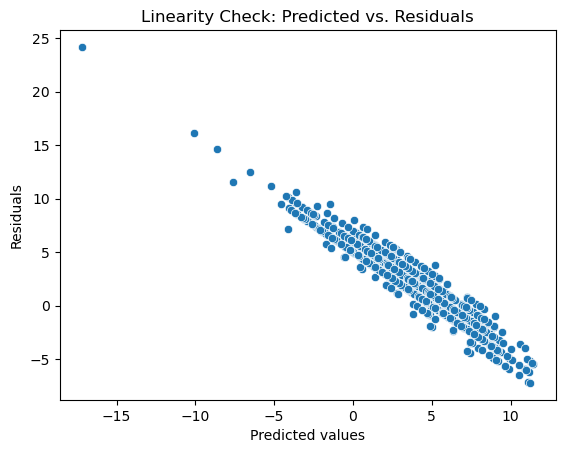

Breusch-Pagan test p-value: 0.0000
Breusch-Pagan test f-statistic p-value: 0.0000


In [21]:
#predict the target variable using the test set
y_pred = reg_model.predict(x_test)

# calculate the residuals
residuals = y_test - y_pred

# plot the residuals against the predicted values
sns.scatterplot(x=y_pred, y=residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Linearity Check: Predicted vs. Residuals")
plt.show()


# perform the Breusch-Pagan test for heteroscedasticity
_, pvalue, _, f_pvalue = het_breuschpagan(residuals, x_test)
print(f"Breusch-Pagan test p-value: {pvalue:.4f}")
print(f"Breusch-Pagan test f-statistic p-value: {f_pvalue:.4f}")

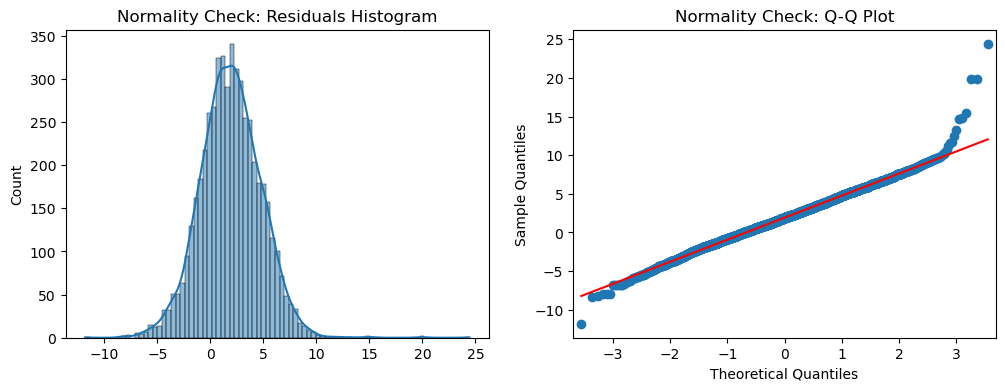

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(reg_model.resid, ax=ax[0], kde=True)
ax[0].set_title("Normality Check: Residuals Histogram")
sm.qqplot(reg_model.resid, ax=ax[1], line="s")
ax[1].set_title("Normality Check: Q-Q Plot")
plt.show()

In [23]:
# predict the target variable using the trained model
y_pred = reg_model.predict(x_test)

# calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
rmse

3.6714668994152633


RMSE is higher now, and after transforming data we can see a little different picture: linearity plot now has a linear pattern, but looking at the Homoscedaciticity test, the Breusch-Pagan test's pvlue should be >0.05 to indicate that the variance of the residuals is constant, but we have it less than 0.05. So model after transformation satisfies more assumptions of a linear model, and it's good for the descrete Y-variabel. However, RMSE has risen significatly, so let's see other models.

For the following Logistic Regression, K-Neighbours Classifier, and random Forest we need to split our quality Y-variable into just three categories: 'satisfactory' (where quality is <5), 'good' (where quality is >5 and <=7), and 'very good', where quality is >7.

In [24]:
accuracies = {}
precisions = {}
recalls = {}

In [25]:
# Scale the data
scaler = StandardScaler()
x_log = scaler.fit_transform(wines_transformed.iloc[:, :-1])
y_log = wines_transformed.iloc[:, -1]

# Encode the target variable
y_log = y_log.apply(lambda x: "satisfactory" if x <= 5 else ("good" if x <= 7 else "very good"))

In [26]:
#Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_log, y_log, test_size=0.3, random_state=42)

In [27]:
# Create a logistic regression model
model = LogisticRegression()

# Train the model on the training set
model.fit(x_train, y_train)

# Predict on the test set
y_pred = model.predict(x_test)

In [28]:
print("Accuracy for Logistic Regression:", accuracy_score(y_test, y_pred))
accuracies['logistic_reg'] = accuracy_score(y_test, y_pred)

log_precision = precision_score(y_test, model.predict(x_test),average='macro')
print("Precision for Logistic Regression: ",log_precision)
precisions['logistic_reg'] = log_precision

log_recall = recall_score(y_test, model.predict(x_test),average='macro')
print("Recall for Logistic Regression: ",log_recall)
recalls['logistic_reg'] = log_recall

Accuracy for Logistic Regression: 0.7102564102564103
Precision for Logistic Regression:  0.4604910273179821
Recall for Logistic Regression:  0.4676316116024813


c:\Users\Eugene\anaconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# split the dataset into features and target variable
x = wines_transformed.drop('quality', axis = 1)
y = wines_transformed.iloc[:, -1]
y = y.apply(lambda x: "satisfactory" if x <= 5 else ("good" if x <= 7 else "very good"))

# scale the features
scaler = StandardScaler()
x = scaler.fit_transform(x)

# split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# create a KNN model and fit it to the training data
k = 5
knc = KNeighborsClassifier(n_neighbors=k)
knc.fit(x_train, y_train)

# predict the target variable for the test set
y_pred = knc.predict(x_test)

In [30]:
print("Accuracy for K-Neighbours Classifier:", accuracy_score(y_test, y_pred))
accuracies['knc_reg'] = accuracy_score(y_test, y_pred)

knc_precision = precision_score(y_test, knc.predict(x_test),average='macro')
print("Precision for K-Neighbours Classifier: ",knc_precision)
precisions['knc_reg'] = knc_precision

knc_recall = recall_score(y_test, knc.predict(x_test),average='macro')
print("Recall for K-Neighbours Classifier: ",knc_recall)
recalls['knc_reg'] = knc_recall

Accuracy for K-Neighbours Classifier: 0.7292307692307692
Precision for K-Neighbours Classifier:  0.6645818976068086
Recall for K-Neighbours Classifier:  0.5195046279991612


KNC has higher accuracy than Logistic regression. Let's take a look at Random Forest Classifier

In [36]:

# Split the dataset into training and test sets
# split the dataset into features and target variable
x = wines_transformed.drop('quality', axis = 1)
y = wines_transformed.iloc[:, -1]
y = y.apply(lambda x: "satisfactory" if x <= 5 else ("good" if x <= 7 else "very good"))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier model
n_estimators = 100
rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
rfc.fit(x_train, y_train)

# Predict the quality of the test set samples using the trained model
y_pred = rfc.predict(x_test)

In [35]:
print("Accuracy for Random Forest Classifier:", accuracy_score(y_test, y_pred))
accuracies['rand_for_cls'] = accuracy_score(y_test, y_pred)

rf_precision = precision_score(y_test, y_pred ,average='macro')
print("Precision for Random Forest Classifier: ",rf_precision)
precisions['rand_for_cls'] = rf_precision

rf_recall = recall_score(y_test, y_pred ,average='macro')
print("Recall for Random Forest Classifier: ",rf_recall)
recalls['rand_for_cls'] = rf_recall

Accuracy for Random Forest Classifier: 0.8092307692307692
Precision for Random Forest Classifier:  0.8392406253497384
Recall for Random Forest Classifier:  0.6438005485524408


In [33]:
print(accuracies)
print(precisions)
print(recalls)

{'logistic_reg': 0.7102564102564103, 'knc_reg': 0.7292307692307692, 'rand_for_reg': 0.8092307692307692}
{'logistic_reg': 0.4604910273179821, 'knc_reg': 0.6645818976068086, 'rand_for_reg': 0.8392406253497384}
{'logistic_reg': 0.4676316116024813, 'knc_reg': 0.5195046279991612, 'rand_for_reg': 0.6438005485524408}


We can see that from all classification models Random Forest Classifier has the highest accuracy. Random Forest Classifier also has the highest Precision, and highest Recall. Random Forest Classsifier is objectively better than any other model in our case. Since Accuracy is the most important eval statistic in our case we will implement 10-fold cross-validation to see if we can improve Accuracy

In [44]:
rfc_cv = cross_val_score(rfc, X = x_train, y = y_train, cv = 10)
rfc_cv.mean()

0.8087398102860529

As we can see accuracy after 10-fold cross-validation is essentially the same as before. This means that our model is relatively stable and consistent in its performance. This is a good sign, as it indicates that our model is likely to generalize well to new , unseen data. Now, let's see how we can tune different hyperparameters.

In [47]:
# Define the hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Create a base RandomForestClassifier
rfc = RandomForestClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(x_train, y_train)

# Check the best hyperparameters
print("Best parameters found: ", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15, 'criterion': 'entropy', 'bootstrap': False}


In [50]:
rfc = RandomForestClassifier(n_estimators=random_search.best_params_['n_estimators'],
                             min_samples_split= random_search.best_params_['min_samples_split'],
                             min_samples_leaf = random_search.best_params_['min_samples_leaf'],
                             max_features = random_search.best_params_['max_features'],
                             max_depth = random_search.best_params_['max_depth'],
                             criterion = random_search.best_params_['criterion'],
                             bootstrap = random_search.best_params_['bootstrap'])
rfc.fit(x_train, y_train)

# Predict the quality of the test set samples using the trained model
y_pred = rfc.predict(x_test)

print("Accuracy for Random Forest Classifier:", accuracy_score(y_test, y_pred))
accuracies['rand_for_cls'] = accuracy_score(y_test, y_pred)

rf_precision = precision_score(y_test, y_pred ,average='macro')
print("Precision for Random Forest Classifier: ",rf_precision)
precisions['rand_for_cls'] = rf_precision

rf_recall = recall_score(y_test, y_pred ,average='macro')
print("Recall for Random Forest Classifier: ",rf_recall)
recalls['rand_for_cls'] = rf_recall

Accuracy for Random Forest Classifier: 0.796923076923077
Precision for Random Forest Classifier:  0.8543612794648658
Recall for Random Forest Classifier:  0.6365752255155115


Although our accuracy is slightly worse than with the default hyperparameters - using the model with tuned hyperpaarmeters ensures that there is lower chance for overfitting. The amin purpose of tuning hyperparameters is to to improve the model's generalization to unseen data.

Through our preperation for 'Paper Review #2', and our on-going research in general, we have noticed that few papers implemented Xgboost Classifier and got better results than with Random Forest Classifier. We decided to do the same and compare with our Random Forest Classifier model.